In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')
from sklearn import decomposition

from sklearn import preprocessing, decomposition, model_selection, linear_model, metrics, ensemble, svm, utils
from sklearn.datasets import make_classification
from sklearn import preprocessing

In [4]:
# Get the data
train_transaction = pd.read_csv('../data/train_transaction.csv')
train_identity = pd.read_csv('../data/train_identity.csv')
# test_transaction = pd.read_csv('../data/test_transaction.csv')
# test_identity = pd.read_csv('../data/test_identity.csv')

In [16]:
# Join datasets
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
# test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(f'Shape of train set: {train.shape}')
# print(f'Shape of test set: {test.shape}')

Shape of train set: (590540, 435)


In [17]:
# Reduce memory usage
def reduce_mem(df):
  start_mem=df.memory_usage().sum()/1024**2
  print('Initial Memory Usage : {:.2f} MB'.format(start_mem))
  for col in df.columns:
    col_type=df[col].dtype
    if col_type != object:
      mn, mx = df[col].min(), df[col].max()
      if str(col_type)[:3]=='int':
        if mn>np.iinfo(np.int8).min and mx<np.iinfo(np.int8).max:
          df[col]=df[col].astype(np.int8)
        elif mn>np.iinfo(np.int16).min and mx<np.iinfo(np.int16).max:
          df[col]=df[col].astype(np.int16)
        elif mn>np.iinfo(np.int32).min and mx<np.iinfo(np.int32).max:
          df[col]=df[col].astype(np.int32)
      else:
        if mn>np.finfo(np.float16).min and mx<np.finfo(np.float16).max:
          df[col]=df[col].astype(np.float16)
        elif mn>np.finfo(np.float32).min and mx<np.finfo(np.float32).max:
          df[col]=df[col].astype(np.float32)
  end_mem = df.memory_usage().sum()/1024**2
  print('Final Memory Usage : {:.2f} MB'.format(end_mem))
  print('Decreased by {:.2f}%'.format(100*(start_mem-end_mem)/start_mem))
  return df

In [7]:
train = reduce_mem(train)

Initial Memory Usage : 1959.88 MB
Final Memory Usage : 648.22 MB
Decreased by 66.93%


In [8]:
# import gc
# del train_transaction, train_identity, test_transaction, test_identity
# gc.collect()

Text(0.5, 1.0, 'Target distribution')

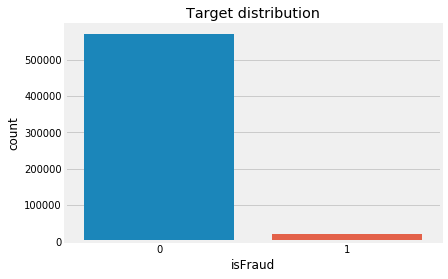

In [18]:
sns.countplot(train['isFraud']) #Imbalanced Dataset
plt.title('Target distribution')

In [19]:
not_fraud = train[train.isFraud==0]
fraud = train[train.isFraud==1]

print(len(not_fraud))
print(len(fraud))

# Downsample the data and re-concatenate
not_fraud_downsampled = utils.resample(not_fraud, replace=False, n_samples = len(fraud), random_state = 27) 
train = pd.concat([not_fraud_downsampled, fraud])

569877
20663


In [20]:
not_fraud = train[train.isFraud==0]
fraud = train[train.isFraud==1]

print(len(not_fraud))
print(len(fraud))

20663
20663


In [21]:
y = train['isFraud'].values

train = train.drop('isFraud', axis=1)
# test = test.copy()

# Delete rows with more than 70%? of NaNs, and fill out the rest with some value
train = train.fillna(-1)
# test = test.fillna(-1) 

In [25]:

# Label Encoding
for f in train.columns:
    if train[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
#       lbl.fit(list(train[f].values) + list(test[f].values))
        lbl.fit(list(train[f].values))
        train[f] = lbl.transform(list(train[f].values))
#       test[f] = lbl.transform(list(test[f].values)) 

In [27]:
scaler = preprocessing.StandardScaler() # MinMaxScaler StandardScaler RobustScaler
cols = list(train.columns)
train[cols] = scaler.fit_transform(train[cols])
# test[cols] = scaler.transform(test[cols])

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

N = 50

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# svd_param_grid = {'n_components':[25, 50, 100, 200], 'n_iters':[5, 10, 15, 20]}
svd = decomposition.TruncatedSVD(n_components=N)
# svd_gs = GridSearchCV(svd, svd_param_grid, cv=10)
# svd_gs.fit(train[cols], y, scoring=scoring)
# sorted(svd_gs.cv_results_.keys())

X = svd.fit_transform(train[cols], y) 
# svd.explained_variance_ratio_.sum()

In [29]:
df = pd.DataFrame()
df["isFraud"] = y

for i in range(50):
    df[i] = X[:,i]
    
df.tail()

,isFraud,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
41321,1,-7.276083,-2.431949,0.646814,2.808476,0.640184,-1.751661,-0.016849,-1.261922,-1.436864,...,0.282639,0.460544,0.366965,-0.524417,1.839353,-0.418180,0.365184,-0.037096,-0.405702,-0.687012
41322,1,2.318632,10.555326,-0.078963,1.527928,-2.989022,3.220783,0.316242,0.116696,-0.251243,...,-0.350644,0.528664,-0.424586,0.626786,0.363555,-0.411206,0.186528,0.131911,-0.509930,0.197590
41323,1,11.628858,-9.553840,-4.769135,4.146200,-3.481114,-0.330705,0.287055,0.696677,2.840569,...,-0.383455,-0.121058,0.520722,0.794682,0.099625,-0.061522,0.920780,-0.772701,-0.231387,-0.352067
41324,1,-6.882393,-2.129048,0.552940,2.688539,0.281518,-1.189546,-0.038160,-1.069363,-1.323501,...,-0.037803,0.149278,0.191911,-0.419619,0.758227,-0.517669,0.885403,0.024368,0.292841,-0.106673
41325,1,11.483212,-9.626314,-4.782605,4.151696,-3.411102,-0.400051,0.255108,0.662173,2.815608,...,1.656035,0.612073,0.095638,0.453482,0.674314,-0.207302,0.857066,-1.025328,-0.405222,-0.379437


In [30]:
 X_train, X_test, y_train, y_test = model_selection.train_test_split(df.drop('isFraud',axis=1), y, test_size=.2, random_state=1)

In [34]:
%%time

skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
arch = "reg"

lr_param_grid = {}
rfc_param_grid = {'n_estimators':[150, 200, 250], 'criterion':('gini', 'entropy')}
svc_param_grid = {}

#reg = linear_model.LogisticRegression(C=1, solver="newton-cg", penalty="l2", n_jobs=-1, max_iter=200).fit(X_train, y_train) 
rfc = ensemble.RandomForestClassifier(n_estimators=200,criterion='gini',n_jobs=-1).fit(X_train, y_train)
# rfc = ensemble.RandomForestClassifier(max_iter=200, n_jobs=-1)
# rfc_gs = GridSearchCV(rfc, rfc_param_grid, cv=10)
# rfc_gs.fit(X_train, y_train)
#reg = svm.SVC(max_iter=200).fit(X_train, y_train)
# try gaussianNB()

y_pred = rfc.predict_proba(X_test)
# print(y_test)
# print(y_pred)
print(metrics.classification_report(y_test, [round(y[1]) for y in y_pred]))
# sorted(rfc_gs.cv_results_.keys())

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      4169
           1       0.81      0.78      0.79      4097

    accuracy                           0.80      8266
   macro avg       0.80      0.80      0.80      8266
weighted avg       0.80      0.80      0.80      8266

CPU times: user 1min 4s, sys: 205 ms, total: 1min 4s
Wall time: 16.8 s


In [45]:
def split_with_PCA(k, x_tr, y_tr):
    svd = decomposition.TruncatedSVD(n_components=k)
    X = svd.fit_transform(x_tr, y_tr) 
    df = pd.DataFrame()
    df["isFraud"] = y
    for i in range(k):
        df[i] = X[:,i]   
    return model_selection.train_test_split(df.drop('isFraud',axis=1), y, test_size=.2, random_state=1)

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import metrics

K = [50, 75, 100, 125, 150, 175, 200]
nn50 = Sequential()
nn75 = Sequential()
nn100 = Sequential()
nn125 = Sequential()
nn150 = Sequential()
nn175 = Sequential()
nn200 = Sequential()
nns = [nn50, nn75, nn100, nn125, nn150, nn175, nn200]
results = []
ind = 0;
batch_size = 5000
num_epochs = 10
for k in K:
    cur_nn = nns[ind]
    ind = ind + 1
    n_cols = k
    x_tr, x_test, y_tr, y_test = split_with_PCA(k, train[cols], y)
    cur_nn.add(Dense(300, activation='relu', input_shape=(n_cols,)))
    cur_nn.add(Dropout(0.2))
    cur_nn.add(Dense(500, activation='relu'))
    cur_nn.add(Dropout(0.2))
    cur_nn.add(Dense(100, activation='relu'))
    cur_nn.add(Dropout(0.2))
    cur_nn.add(Dense(25, activation='relu'))
    cur_nn.add(Dropout(0.2))
    cur_nn.add(Dense(1, activation='sigmoid'))
    cur_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'categorical_accuracy'])
    x_vl, y_vl = x_tr[:batch_size], y_tr[:batch_size]
    x_train, y_train = x_tr[batch_size:], y_tr[batch_size:]
    print("For k=" + str(k))
    cur_nn.fit(x_train, y_train, validation_data=(x_vl, y_vl), epochs=num_epochs, batch_size=batch_size)
    res = cur_nn.evaluate(x_test, y_test, batch_size=128, verbose=0)
    results.append(res)
    print('test loss, test acc, categorical accuracy:', res)
    



For k=50
Train on 28060 samples, validate on 5000 samples
Epoch 1/10
28060/28060 [==============================] - 3s 102us/sample - loss: 0.6160 - accuracy: 0.6640 - categorical_accuracy: 1.0000 - val_loss: 0.5401 - val_accuracy: 0.7286 - val_categorical_accuracy: 1.0000
Epoch 2/10
28060/28060 [==============================] - 1s 53us/sample - loss: 0.5473 - accuracy: 0.7249 - categorical_accuracy: 1.0000 - val_loss: 0.5172 - val_accuracy: 0.7404 - val_categorical_accuracy: 1.0000
Epoch 3/10
28060/28060 [==============================] - 1s 53us/sample - loss: 0.5280 - accuracy: 0.7382 - categorical_accuracy: 1.0000 - val_loss: 0.5097 - val_accuracy: 0.7460 - val_categorical_accuracy: 1.0000
Epoch 4/10
28060/28060 [==============================] - 1s 53us/sample - loss: 0.5198 - accuracy: 0.7424 - categorical_accuracy: 1.0000 - val_loss: 0.4997 - val_accuracy: 0.7526 - val_categorical_accuracy: 1.0000
Epoch 5/10
28060/28060 [==============================] - 2s 59us/sample - loss: 

28060/28060 [==============================] - 3s 104us/sample - loss: 0.6476 - accuracy: 0.6372 - categorical_accuracy: 1.0000 - val_loss: 0.5528 - val_accuracy: 0.7098 - val_categorical_accuracy: 1.0000
Epoch 2/10
28060/28060 [==============================] - 2s 55us/sample - loss: 0.5586 - accuracy: 0.7141 - categorical_accuracy: 1.0000 - val_loss: 0.5232 - val_accuracy: 0.7336 - val_categorical_accuracy: 1.0000
Epoch 3/10
28060/28060 [==============================] - 2s 56us/sample - loss: 0.5317 - accuracy: 0.7389 - categorical_accuracy: 1.0000 - val_loss: 0.5063 - val_accuracy: 0.7422 - val_categorical_accuracy: 1.0000
Epoch 4/10
28060/28060 [==============================] - 2s 59us/sample - loss: 0.5109 - accuracy: 0.7496 - categorical_accuracy: 1.0000 - val_loss: 0.4899 - val_accuracy: 0.7536 - val_categorical_accuracy: 1.0000
Epoch 5/10
28060/28060 [==============================] - 2s 58us/sample - loss: 0.4986 - accuracy: 0.7551 - categorical_accuracy: 1.0000 - val_loss: 

28060/28060 [==============================] - 2s 66us/sample - loss: 0.5518 - accuracy: 0.7189 - categorical_accuracy: 1.0000 - val_loss: 0.5154 - val_accuracy: 0.7388 - val_categorical_accuracy: 1.0000
Epoch 3/10
28060/28060 [==============================] - 2s 57us/sample - loss: 0.5245 - accuracy: 0.7388 - categorical_accuracy: 1.0000 - val_loss: 0.4947 - val_accuracy: 0.7508 - val_categorical_accuracy: 1.0000
Epoch 4/10
28060/28060 [==============================] - 2s 57us/sample - loss: 0.5019 - accuracy: 0.7527 - categorical_accuracy: 1.0000 - val_loss: 0.4831 - val_accuracy: 0.7594 - val_categorical_accuracy: 1.0000
Epoch 5/10
28060/28060 [==============================] - 2s 57us/sample - loss: 0.4868 - accuracy: 0.7653 - categorical_accuracy: 1.0000 - val_loss: 0.4733 - val_accuracy: 0.7698 - val_categorical_accuracy: 1.0000
Epoch 6/10
28060/28060 [==============================] - 2s 59us/sample - loss: 0.4755 - accuracy: 0.7702 - categorical_accuracy: 1.0000 - val_loss: 0

In [51]:
import sklearn

ind = 0
for model in nns:
    k = K[ind]
    ind = ind + 1
    _, x_test, _, y_test = split_with_PCA(k, train[cols], y)
    y_pred = model.predict(x_test)
    print(sklearn.metrics.classification_report(y_test, [round(y[0]) for y in y_pred]))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      4169
           1       0.76      0.72      0.74      4097

    accuracy                           0.75      8266
   macro avg       0.75      0.75      0.75      8266
weighted avg       0.75      0.75      0.75      8266

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      4169
           1       0.79      0.74      0.76      4097

    accuracy                           0.77      8266
   macro avg       0.77      0.77      0.77      8266
weighted avg       0.77      0.77      0.77      8266

              precision    recall  f1-score   support

           0       0.75      0.83      0.78      4169
           1       0.80      0.71      0.75      4097

    accuracy                           0.77      8266
   macro avg       0.77      0.77      0.77      8266
weighted avg       0.77      0.77      0.77      8266

              preci